In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/drive')

/


In [ ]:
import os
os.makedirs("/content/dataset")

In [ ]:
!unzip "/content/drive/MyDrive/Dataset/patches.zip" -d "/content/dataset/"

Archive:  /content/drive/MyDrive/Dataset/patches.zip
   creating: /content/dataset/patches/
   creating: /content/dataset/patches/Foot Ulcer/
  inflating: /content/dataset/patches/Foot Ulcer/0033.png  
  inflating: /content/dataset/patches/Foot Ulcer/0124.png  
  inflating: /content/dataset/patches/Foot Ulcer/0190.png  
  inflating: /content/dataset/patches/Foot Ulcer/0303.png  
  inflating: /content/dataset/patches/Foot Ulcer/0365.png  
  inflating: /content/dataset/patches/Foot Ulcer/0390.png  
  inflating: /content/dataset/patches/Foot Ulcer/0398.png  
  inflating: /content/dataset/patches/Foot Ulcer/0412.png  
  inflating: /content/dataset/patches/Foot Ulcer/0437.png  
  inflating: /content/dataset/patches/Foot Ulcer/0438.png  
  inflating: /content/dataset/patches/Foot Ulcer/0439.png  
  inflating: /content/dataset/patches/Foot Ulcer/0447.png  
  inflating: /content/dataset/patches/Foot Ulcer/0470.png  
  inflating: /content/dataset/patches/Foot Ulcer/0475.png  
  inflating: /cont

In [ ]:
import os
import time
import shutil
import random
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from PIL import Image

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# previous

In [ ]:
# Define paths to source and destination folders
source_folder = "/content/dataset/patches"
train_folder = "/content/dataset/train"
validation_folder = "/content/dataset/validation"


In [ ]:

# List of class names (subfolder names)
class_names = ["Foot Ulcer", "Normal"]

# Create train and validation folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# Define the percentage split
train_percentage = 80

# Loop through each class
for class_name in class_names:
    class_source_folder = os.path.join(source_folder, class_name)
    class_train_folder = os.path.join(train_folder, class_name)
    class_validation_folder = os.path.join(validation_folder, class_name)

    # Create class subfolders in train and validation folders
    os.makedirs(class_train_folder, exist_ok=True)
    os.makedirs(class_validation_folder, exist_ok=True)

    image_files = [f for f in os.listdir(class_source_folder) if f.endswith(".jpg") or f.endswith(".png")]

    # Shuffle the image files
    random.shuffle(image_files)

    # Calculate the number of images for training
    num_train = int(len(image_files) * (train_percentage / 100))

    # Move images to train folder
    for img_file in image_files[:num_train]:
        src_path = os.path.join(class_source_folder, img_file)
        dst_path = os.path.join(class_train_folder, img_file)
        shutil.copy(src_path, dst_path)

    # Move remaining images to validation folder
    for img_file in image_files[num_train:]:
        src_path = os.path.join(class_source_folder, img_file)
        dst_path = os.path.join(class_validation_folder, img_file)
        shutil.copy(src_path, dst_path)


In [ ]:
# Initialize dictionaries to store counts
train_counts = {}
validation_counts = {}

# Loop through each class
for class_name in class_names:
    class_train_folder = os.path.join(train_folder, class_name)
    class_validation_folder = os.path.join(validation_folder, class_name)

    # Count files in train and validation folders
    train_file_count = len([f for f in os.listdir(class_train_folder) if os.path.isfile(os.path.join(class_train_folder, f))])
    validation_file_count = len([f for f in os.listdir(class_validation_folder) if os.path.isfile(os.path.join(class_validation_folder, f))])

    # Store counts in dictionaries
    train_counts[class_name] = train_file_count
    validation_counts[class_name] = validation_file_count

# Print the counts
print("Train Counts:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} files")

print("\nValidation Counts:")
for class_name, count in validation_counts.items():
    print(f"{class_name}: {count} files")


Train Counts:
Foot Ulcer: 686 files
Normal: 499 files

Validation Counts:
Foot Ulcer: 260 files
Normal: 125 files


In [ ]:
DATA_DIR = '/content/dataset'
print(os.listdir(path=DATA_DIR))

['validation', 'train', 'patches']


In [ ]:
batch_size = 32
image_shape = (225,225)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range=0.2,
                                   zoom_range = [0.8, 1.2], horizontal_flip=True,
                                   brightness_range= [0.7, 1.3],width_shift_range=0.2,
                                   height_shift_range=0.2, fill_mode='nearest',
                                   preprocessing_function=add_noise) #preprocessing_function=add_noise

train = train_datagen.flow_from_directory(directory='/content/dataset/train',
                                       target_size=image_shape, batch_size=batch_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='/content/dataset/validation',
                                          target_size=image_shape, batch_size=batch_size,
                                          class_mode='categorical', color_mode='rgb', shuffle=True)

Found 1185 images belonging to 2 classes.
Found 385 images belonging to 2 classes.


{'Foot Ulcer': 0, 'Normal': 1}


TypeError: ignored

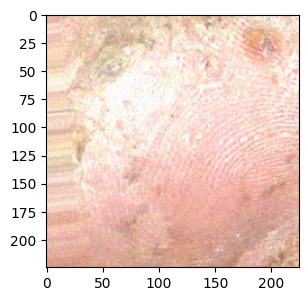

In [ ]:
print(train.class_indices)
train.classes

# Show photos of  dataset
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(2,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# low accuracy

In [ ]:
input_shape = (225, 225, 3)

model = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)
for i,layer in enumerate(model.layers):
    print(i,layer.name)
print("\nInput:", model.input)
print("Output:", model.output)

94765736/94765736 [==============================] - 1s 0us/step
0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv

In [ ]:
input_shape = (225, 225, 3)
pre_trained_model = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(32, activation='relu')(x)
# Dropout layer to reduce overfitting
x = Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)

model.compile(keras.optimizers.Adagrad(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 225, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 231, 231, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 113, 113, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',
                                              save_best_only=True)

history = model.fit_generator(
    train,
    steps_per_epoch=len(train),
    epochs=20,
    validation_data=val,
    validation_steps=len(val),
    verbose=1,
    callbacks=[checkpoint])

<ipython-input-20-1e40bc422bfe>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.65873, saving model to training_save.h5
32/32 [==============================] - 353s 11s/step - loss: 1.0429 - accuracy: 0.5135 - val_loss: 0.6676 - val_accuracy: 0.6587
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5723
Epoch 2: val_accuracy did not improve from 0.65873
32/32 [==============================] - 322s 10s/step - loss: 0.6883 - accuracy: 0.5723 - val_loss: 0.6760 - val_accuracy: 0.5675
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5673
Epoch 3: val_accuracy did not improve from 0.65873
32/32 [==============================] - 338s 11s/step - loss: 0.6848 - accuracy: 0.5673 - val_loss: 0.6655 - val_accuracy: 0.5675
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5862
Epoch 4: val_accuracy did not improve from 

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "foot_ulcer_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                              patience=3,
                              restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train,
    steps_per_epoch=len(train),
    validation_data=val,
    validation_steps=len(val),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/50
32/32 [==============================] - 38s 746ms/step - loss: 0.7181 - accuracy: 0.4327 - val_loss: 0.6724 - val_accuracy: 0.4325
Epoch 2/50
32/32 [==============================] - 22s 697ms/step - loss: 0.6790 - accuracy: 0.4327 - val_loss: 0.6668 - val_accuracy: 0.4325
Epoch 3/50
32/32 [==============================] - 21s 655ms/step - loss: 0.6698 - accuracy: 0.4327 - val_loss: 0.6537 - val_accuracy: 0.4325
Epoch 4/50
32/32 [==============================] - 23s 705ms/step - loss: 0.6695 - accuracy: 0.4327 - val_loss: 0.6402 - val_accuracy: 0.4325
Epoch 5/50
32/32 [==============================] - 21s 642ms/step - loss: 0.6605 - accuracy: 0.4327 - val_loss: 0.6305 - val_accuracy: 0.4325
Epoch 6/50
32/32 [==============================] - 22s 689ms/step - loss: 0.6525 - accuracy: 0.4327 - val_loss: 0.6172 - val_accuracy: 0.4325
Epoch 7/50
32/32 [==============================] - 22s 682ms/step - loss: 0.6469 - accuracy: 0.4327 - val_loss: 0.6064 - val_accuracy: 0.4325

# Define a function to show example training images¶


In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [ ]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)

# Define a function to print text in RGB foreground and background colors

In [ ]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
  #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
  #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)

  rf,gf,bf=fore_tupple
  rb,gb,bb=back_tupple

  msg = '{0}' + txt_msg
  mat = '\33[38;2;' +str(rf)+ ';' + str (gf) + ';' + str(bf) + ';48;2;' +str(rb)+ ';' + str(gb)+ ';' + str(bb)+ 'm'
  print(msg .format(mat), flush=True)
  print('\33[0m', flush=True) #returns default print color to back to black
  return

# Define a subclass of Keras callbacks that will control the learning rate and print

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0
        self.best_epoch=1   # epoch with the lowest loss
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored

    def on_train_begin(self, logs=None):
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'
        print_in_color (msg, (244, 252, 3), (55,65,80))
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
        self.start_time= time.time()

    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count

    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc

        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))
                        self.count=0
                        self.stop_count=0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial

                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))





Function for plot the training data

In [ ]:
def tr_plot(tr_data, start_epoch):

  #Plot the training and validation data
  tacc= tr_data.history['accuracy']
  tloss = tr_data.history['loss']
  vacc = tr_data.history['val_accuracy']
  vloss = tr_data.history['val_loss']
  Epoch_count = len(tacc)+start_epoch
  Epochs = []

  for i in range(start_epoch, Epoch_count):
    Epochs.append(i+1)
  index_loss = np.argmin(vloss) #  this is the epoch with the lowest validation loss
  val_lowest = vloss[index_loss]
  index_acc = np.argmax(vacc)
  acc_highest = vacc[index_acc]
  plt.style.use('fivethirtyeight')
  sc_label = 'best epoch= '+str(index_loss+1 + start_epoch)
  vc_label = 'best epoch= '+str(index_acc+1 + start_epoch)
  fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))

  axes[0].plot(Epochs, tloss, 'r', label = 'Training loss')
  axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
  axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
  axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
  axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()
  plt.tight_layout
  #plt.style.use('fivethirtyeight')
  plt.show()


Define a fuction for confuion matrix and classic report

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

Function for save model and csv file

In [ ]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):

  save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
  model_save_loc = os.path.join(save_path, save_id)
  model.save(model_save_loc)
  print_in_color ('model was saved as' + model_save_loc, (0,255,0),(55,65,80))

  class_dict = generator.class_indices
  height = []
  width = []
  scale = []

  for i in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])
    scale.append(scalar)

  Index_series = pd.Series(list(class_dict.values()), name =  'class_index')
  Class_series = pd.Series(list(class_dict.values()), name =  'class')
  Height_series = pd.Series(height, name='height')
  Width_series = pd.Series(width, name ='width')
  Scale_series = pd.Series(scale, name='scale by')
  class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)

  csv_name='class_dict.csv'
  csv_save_loc=os.path.join(save_path, csv_name)
  class_df.to_csv(csv_save_loc, index=False)
  print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))

  return model_save_loc, csv_save_loc

predictor

In [ ]:
def predictor(sdir, csv_path,  model_path, crop_image = False):
    # read in the csv file
    class_df=pd.read_csv(csv_path)
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0]
    try:
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)
    index_list=[]
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))
            index=np.argmax(p)
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
       key= index_list[i]
       keycount=0
       for j in range (i+1, len(index_list)):
            nkey= index_list[j]
            if nkey == key:
                keycount +=1
       if keycount> most:
            most=keycount
            isave=i
    best_index=index_list[isave]
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]
    img= cropped_image_list[isave]/255
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count, img

define a function tha takes in a dataframe df, and integer max_size and a string column and returns a dataframe where the number of samples for any class specified by column is limited to max samples

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[]
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

(224, 224, 3)


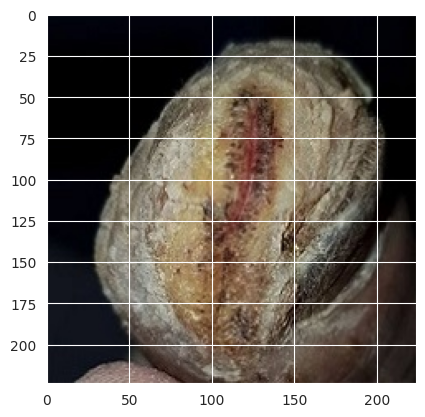

In [ ]:
fpath=r'/content/dataset/patches/Foot Ulcer/1.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [ ]:
def preprocess(sdir, trsplit):
    filepaths = []
    labels = []
    classlist = os.listdir(sdir)
    for klass in classlist:
        classpath = os.path.join(sdir, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    # split df into train_df and valid_df
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)

    print('train_df length: ', len(train_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())

    return train_df, valid_df

In [ ]:
sdir=r'/content/dataset/patches'
train_df, valid_df= preprocess(sdir, .8)

train_df length:  864   valid_df length:  217
Normal(Healthy skin)    442
Foot Ulcer              422
Name: labels, dtype: int64


In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    else:
        ndf=train_df
    print (list(ndf['labels'].value_counts()) )
    return ndf

In [ ]:
EXPLAINABLE_MODELS = {
    'linear_regression': LinearRegression,
    'decision_tree_regressor': DecisionTreeRegressor
}


In [ ]:
from typing import Tuple
from sklearn.metrics import pairwise_distances

class LIME:

    def __init__(self, image: tf.Tensor, model: tf.keras.Model, random_seed: int = 9):
        """
        Parameters
        ----------
        image: tf.Tensor; Image for which the explanation should be made
        model: tf.keras.Model; Base model
        """
        self.image = image
        self.model = model
        self.random_seed = random_seed
        self.super_pixels, self.super_pixel_count = self.create_super_pixels()
        self.perturbation_vectors = self.generate_pertubation_vectors()

    def create_super_pixels(
            self, kernel_size: int = 8, max_dist: int = 1000, ratio: float = 0.2
    ) -> Tuple[np.ndarray, int]:
        """
        Parameters
        ----------
        kernel_size, max_dist, ratio: parameters for skimage.segmentation.quickshift function.
        See https://scikit-image.org/docs/stable/api/skimage.segmentation.html for more info

        Returns
        -------
        super_pixels: np.ndarray (shape==self.image.shape); Contains
        integers to which super pixel area the location belongs
        super_pixel_count: int; total number of different superpixel areas
        """
        super_pixels = skimage.segmentation.quickshift(
            self.image, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio
        )
        super_pixel_count = len(np.unique(super_pixels))
        return super_pixels, super_pixel_count

    def plot_super_pixel_boundary(self):
        """ Plots the boundaries of the superpixel areas """
        super_pixel_boundaries = skimage.segmentation.mark_boundaries(
            self.image.numpy().astype(int), self.super_pixels
        )
        plt.imshow(super_pixel_boundaries)
        plt.title('Superpixel boundaries')

    def generate_pertubation_vectors(self, num_perturbations: int = 100) -> np.ndarray:
        """
        Generates a number of perturbation vectors. These are binary vectors of length
        num_super_pixels, which define if a superpixel is perturbed

        Parameters
        ----------
        num_perturbations: int; total number of perturbations

        Returns
        -------
        np.ndarray (shape=(num_perturbations, super_pixel_count); binary array defining if a
        superpixel area should be perturbed
        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        return np.random.binomial(1, 0.5, size=(num_perturbations, self.super_pixel_count))

    def predict_perturbed_images(self) -> np.ndarray:
        """
        Generates predictions for all perturbed_images

        Returns
        -------
        np.ndarray (shape=(num_perturbations, num_output_classes)); contains predictions for all
        perturbed images
        """
        perturbed_images = self.create_perturbed_images()
        return self.model(perturbed_images).numpy()

    def create_perturbed_images(self) -> np.ndarray:
        """ Creates perturbed images based on all pertubation vectors """
        self.generate_pertubation_vectors()
        return np.apply_along_axis(
            lambda x: self._create_perturbed_image(x), 1, self.perturbation_vectors
        )

    def _create_perturbed_image(self, perturbation_vector: np.ndarray) -> np.ndarray:
        """
        Creatas a single perturbed image

        Parameters
        ----------
        perturbation_vector; np.ndarray (shape=(num_perturbations, super_pixel_count); binary array
        defining if a superpixel area should be perturbed

        Returns
        -------
        np.ndarray (shape==self.image.shape); contains original image info or perturbed image
        dependent on the perturbation_vector
        """
        perturbation_mask = np.isin(self.super_pixels, np.argwhere(perturbation_vector == 1))
        return np.where(np.expand_dims(perturbation_mask, -1), self.image, 0)

    def plot_perturbed_image(self):
        """ Plots a single perturbed image """
        if self.perturbation_vectors is None:
            self.generate_pertubation_vectors()

        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        idx = np.random.randint(len(self.perturbation_vectors))
        perturbed_img = self._create_perturbed_image(self.perturbation_vectors[idx])

        plt.imshow(perturbed_img.astype(int))
        plt.title('Perturbed Image')

    def calculate_perturbation_weights(self, kernel_width: float = 0.25) -> np.ndarray:
        """
        Calculates the perturbation weights. First the distance between the perturbed images
        and the original image is calculated. A kernel function is used to map these distances
        to weights. The smaller the distance to the original image, the larger the weight. The
        intuition behind this is that if a perturbed image is very close to the original image,
        (let's say only 1 perturbed superpixel area), there is a lot of information in this
        sample, as it tells a lot on the 1 perturbed superpixel area importance.

        Parameters
        ----------
        kernel_width: float; defines the width of the kernel that is used

        Returns
        -------
        np.ndarray (shape=(num_perturbations,)); weights for each perturbation
        """
        non_perturbed_vector = np.ones((1, self.super_pixel_count))
        distances = pairwise_distances(
            self.perturbation_vectors, non_perturbed_vector, metric='cosine'
        )
        return np.squeeze(np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2)))

    def _fit_explainable_model(
            self,
            predictions: np.ndarray,
            weights: np.ndarray,
            explainable_model_type: str = 'decision_tree_regressor'
    ) -> np.ndarray:
        """
        Function to fit an exmplainable model and define the importance of each superpixel area

        Parameters
        ----------
        predictions: np.ndarray (shape=(num_perturbations, num_output_classes)); contains
        predictions for all perturbed images
        weights: np.ndarray (shape=(num_perturbations,)); weights for each perturbation
        explainable_model_type: str containing the type of explainable model

        Returns
        -------
        feature_importances: np.ndarray (shape=(super_pixel_count,)); importance of each superpixel
        for predicting a specific class
        """
        if explainable_model_type not in EXPLAINABLE_MODELS.keys():
            raise ValueError(
                f"Please specify one of the following model_types: {EXPLAINABLE_MODELS.keys()}"
            )

        model = EXPLAINABLE_MODELS[explainable_model_type]()
        model.fit(X=self.perturbation_vectors, y=predictions, sample_weight=weights)
        if 'regression' in explainable_model_type:
            feature_importance = model.coef_
        elif 'tree' in explainable_model_type:
            feature_importance = model.feature_importances_
        else:
            raise ValueError(
                f"Please specify one of the following model_types: {EXPLAINABLE_MODELS.keys()}"
            )

        return feature_importance

    def plot_explainable_image(self, class_to_explain: int = None, num_superpixels: int = 4,
                               explainable_model_type: str = 'decision_tree_regressor'):
        """
        Plots the most important super pixel areas for predicting a specific class

        Parameters
        ----------
        class_to_explain: int; which class to plot the explanations for. If not specified, will
        default to the class with the highest probability
        num_superpixels: int; defines how many superpixel areas will be plotted
        explainable_model_type: str; which explainable model to use to generate explainability plot
        """
        # get perturbed image predictions & weights
        perturbed_image_predictions = self.predict_perturbed_images()
        weights = self.calculate_perturbation_weights()

        if class_to_explain is None:
            class_to_explain = np.argmax(self.model(np.expand_dims(self.image, 0)).numpy())

        # fit simple interpretable model
        feature_importance = self._fit_explainable_model(
            predictions=perturbed_image_predictions[:, class_to_explain],
            weights=weights,
            explainable_model_type=explainable_model_type
        )

        # Define which superpixel areas should be plotted
        superpixels_to_plot = np.argsort(feature_importance)[-num_superpixels:]
        superpixel_vector = np.zeros(self.super_pixel_count)
        np.put(superpixel_vector, superpixels_to_plot, v=1)

        # Create the image
        perturbed_img = self._create_perturbed_image(superpixel_vector)
        plt.imshow(perturbed_img.astype(int))
        plt.title('LIME explanation')


In [ ]:
max_samples= 422
min_samples=0
column='labels'
working_dir = r'/content/dataset/patches'
img_size=(224,224)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[422, 422, 2]
Found 0 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(valid_df)
valid_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/valid_batch_size)
print ( 'valid batch size: ' ,valid_batch_size, '  valid steps: ', test_steps)
def scalar(img):
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)


valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

valid batch size:  31   valid steps:  7
Found 864 validated image filenames belonging to 2 classes.
Found 217 validated image filenames belonging to 2 classes.


In [ ]:
show_image_samples(train_gen)


In [ ]:
model_name='EfficientNetB2'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

NameError: ignored

mobilenetV3

In [ ]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=31
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     6.923   93.403   9.26399  65.438   0.00100  0.00100  val_loss     0.00    70.67  

 2 /40     5.198   97.917   5.24619  95.853   0.00100  0.00100  val_loss    43.37    10.85  

 3 /40     4.135   98.380   4.08896  98.157   0.00100  0.00100  val_loss    22.06    11.49  

 4 /40     3.382   99.537   3.26419  99.078   0.00100  0.00100  val_loss    20.17    11.03  

 5 /40     2.855   98.958   2.76629  99.078   0.00100  0.00100  val_loss    15.25    11.19  

enter H to halt  or an integer for number of epochs to run then ask again

5
 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     2.468   98.958   2.39345  99.539   0.00100  0.00100  val_loss    13.48    11.18  

 7 /40     2.113   99.884   1.99066  99.539   0.00100  0.00100  val_

efficientNetB3

In [ ]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=val,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     6.738   80.243   8.80801  46.642   0.00010  0.00010  accuracy     0.00    55.58  

 2 /40     6.346   86.049   7.50546  46.642   0.00010  0.00010  accuracy     7.23    23.47  

 3 /40     6.003   89.045   6.85617  46.642   0.00010  0.00010  accuracy     3.48    22.40  

 4 /40     5.720   89.232   6.41973  46.642   0.00010  0.00010  accuracy     0.21    22.63  

 5 /40     5.399   90.356   6.16690  46.642   0.00010  0.00010  val_loss     3.94    23.98  

enter H to halt  or an integer for number of epochs to run then ask again

15
 training will continue until epoch 20

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     5.150   90.918   5.85595  46.642   0.00010  0.00010  val_loss     5.04    36.55  

 7 /40     4.880   91.573   5.62597  46.642   0.00010  0.00010  val

densenet121

In [ ]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=val,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     7.234   84.270   7.10670  98.134   0.00010  0.00010  accuracy     0.00    107.40 

 2 /40     6.488   95.225   6.46240  95.896   0.00010  0.00010  val_loss     9.07    27.59  

 3 /40     5.911   96.255   5.99055  98.507   0.00010  0.00010  val_loss     7.30    27.53  

 4 /40     5.375   96.910   5.58189  98.507   0.00010  0.00010  val_loss     6.82    27.35  

 5 /40     4.882   98.127   5.36205  97.761   0.00010  0.00010  val_loss     3.94    28.18  

enter H to halt  or an integer for number of epochs to run then ask again

10
 training will continue until epoch 15

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     4.441   98.034   4.87067  98.507   0.00010  0.00010  val_loss     9.16    27.59  

 7 /40     4.048   97.659   5.20443  86.194   0.00010  0.00005  val

In [ ]:
length=268
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)


In [ ]:
working_dir = '/content/drive/MyDrive/Dataset'

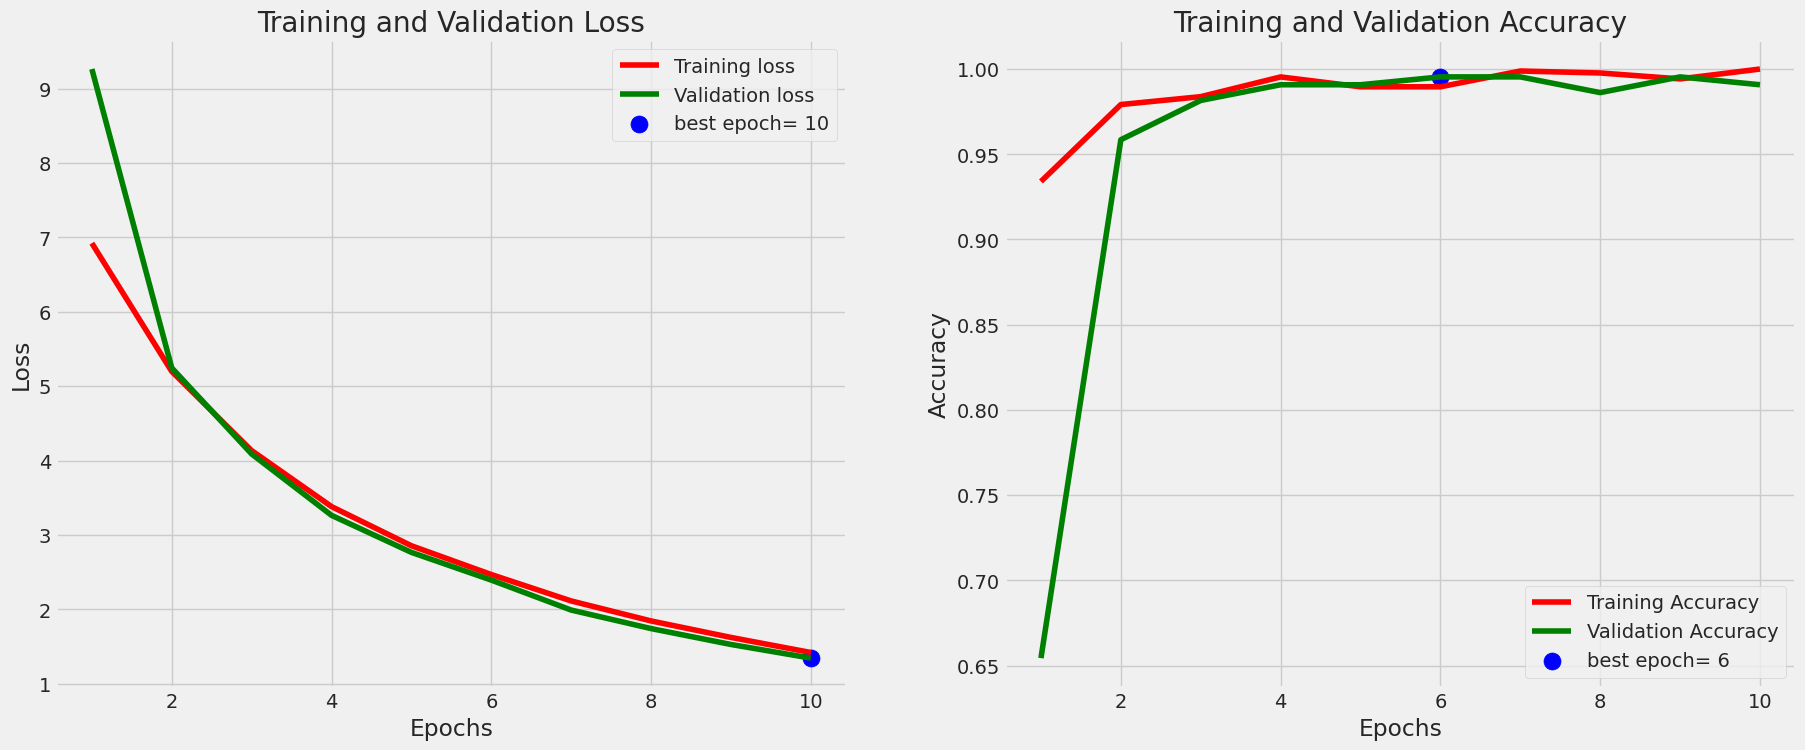

7/7 [==============================] - 1s 158ms/step - loss: 1.3443 - accuracy: 0.9905
accuracy on the test set is 99.05 %



In [ ]:
tr_plot(history,0)
subject='ulcers'
acc=model.evaluate( valid_gen, batch_size=31, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1


In [ ]:
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as/content/drive/MyDrive/Dataset/EfficientNetB3-ulcers-99.04.h5

class csv file was saved as /content/drive/MyDrive/Dataset/class_dict.csv



8/8 [==============================] - 3s 86ms/step


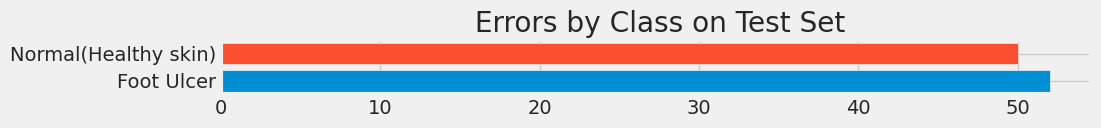

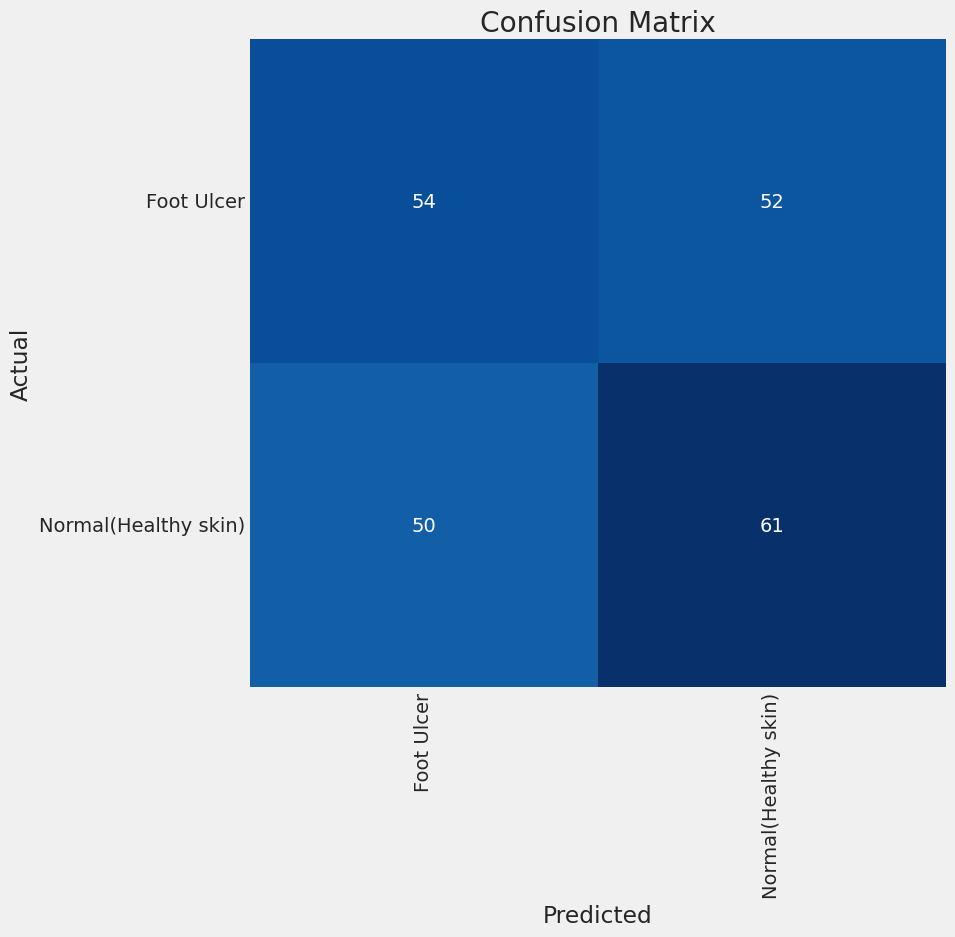

Classification Report:
----------------------
                       precision    recall  f1-score   support

          Foot Ulcer       0.52      0.51      0.51       106
Normal(Healthy skin)       0.54      0.55      0.54       111

            accuracy                           0.53       217
           macro avg       0.53      0.53      0.53       217
        weighted avg       0.53      0.53      0.53       217



In [ ]:
print_code=0
preds=model.predict(valid_gen)
print_info(valid_gen, preds, print_code, working_dir, subject )

In [ ]:
from keras.models import load_model

model_final = load_model('/content/drive/MyDrive/Dataset/EfficientNetB3_ulcer_classify.04.h5')

In [ ]:
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [ ]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of an ulcer
img_path=r'/content/dataset/patches/aug/foot.PNG'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# model was trained on rgb images so convert image to rgb
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

 Model is being loaded- this will take about 10 seconds
1/1 [==============================] - 5s 5s/step
 image is of class Ulcer with a probability of  97.56 %



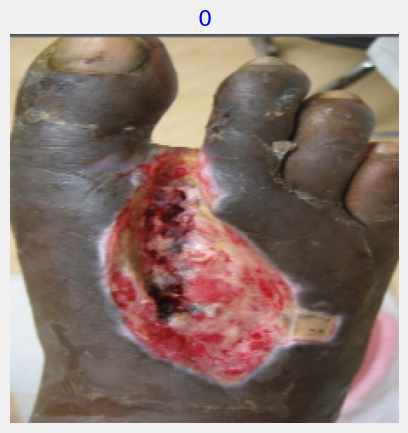

In [ ]:

csv_path='/content/drive/MyDrive/Dataset/class_dict.csv'
model_path= '/content/drive/MyDrive/Dataset/EfficientNetB3_ulcer_classify.04.h5'
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
if class_name ==0:
  class_name = 'Ulcer'
else:
  class_name = 'Normal'
msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

## Lime/Shape

In [ ]:
model = load_model('/content/drive/MyDrive/Dataset/EfficientNetB3_ulcer_classify.04.h5')

In [ ]:
!pip install LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LIME: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=516b5b742d127f973819da257b2834a22fbd4dd06291be4b0777393b9f82eba1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built LIME


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def preprocess_image(x):
  img=tf.image.resize(x, (224,224))
  return img


In [ ]:
import cv2

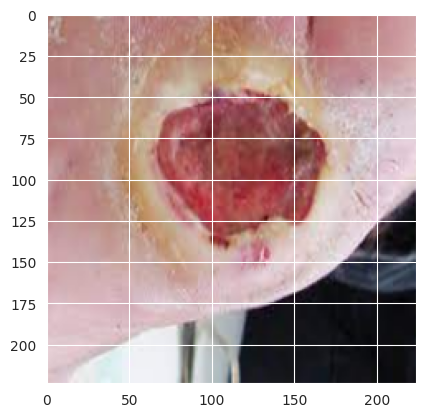

In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming preprocess_image returns a NumPy array
img = Image.open('/content/drive/MyDrive/Dataset/images.jpeg')
img = preprocess_image(np.array(img).astype(int))

# Ensure img is not None
if img is not None:


    plt.imshow(img.numpy().astype(int));
    plt.show()
else:
    print("Image is None. Check the preprocess_image function.")


In [ ]:
img.shape

TensorShape([224, 224, 3])

In [ ]:
preds = model(np.expand_dims(img,0))

In [ ]:
from skimage.segmentation import mark_boundaries
import skimage


In [ ]:
LIME = LIME(img, model)

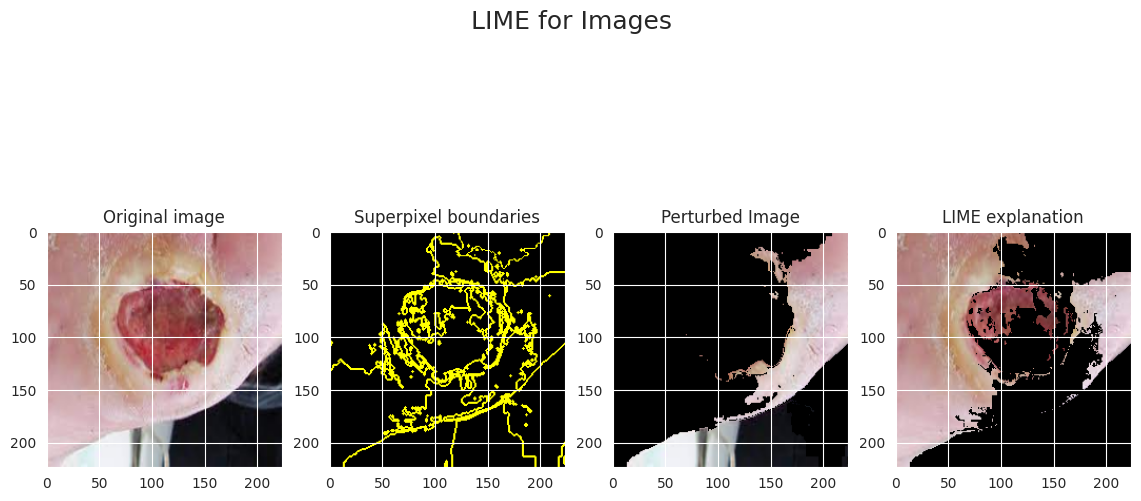

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(141)
plt.imshow(img.numpy().astype(int))
plt.title('Original image')
plt.subplot(142)
LIME.plot_super_pixel_boundary()
plt.subplot(143)
LIME.plot_perturbed_image()
plt.subplot(144)
LIME.plot_explainable_image(explainable_model_type='decision_tree_regressor')
plt.suptitle('LIME for Images', size=18)
plt.show()

In [ ]:

# Take a random sample of 5000 training images
background = train_df[np.random.choice(train_df.shape[0], 5, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

KeyError: ignored